In [14]:
import pandas as pd
import numpy as np
import re
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from pymorphy2 import MorphAnalyzer  
from nltk.corpus import stopwords
from deeppavlov.models.embedders.elmo_embedder import ELMoEmbedder
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score  
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping  
from tensorflow.keras.layers import Dense, Dropout, Activation

# Загрузка данных

In [4]:
df = pd.read_csv("data/women-clothing-accessories.3-class.balanced.csv", sep='\t')

# Предобработка текстов

In [5]:
def preprocessing(df, column, cache):
    #токенизация и удаление символов
    func = lambda text: re.split('-|\s', clean_text(text))
    df.iloc[:, column] = [func(text) for text in df.iloc[:, column].values]
    #удаление отдельностоящих чисел
    func = lambda tokens: [token for token in tokens if token.isdigit() == False]
    df.iloc[:, column] = [func(tokens) for tokens in df.iloc[:, column].values]
    #удаление слов длины меньше 3
    df.iloc[:, column] = [del_word(tokens) for tokens in df.iloc[:, column].values]
    #удаление стоп слов
    stop = set(stopwords.words('russian'))
    exceptions = {"ничего", "хорошо", "никогда", "лучше", "конечно", "совсем", "нельзя", "больше", "наконец", "более", "не"}
    stop = stop.difference(exceptions)
    func = lambda tokens:[token for token in tokens if token not in stop]
    df.iloc[:, column] = [func(tokens) for tokens in df.iloc[:, column].values]
#     #лемматизация
#     lemmatizer = MorphAnalyzer()
#     df.iloc[:, column] = [to_lemmatize(lemmatizer, tokens, cache) for tokens in df.iloc[:, column].values]
    return df

def clean_text(text):
    text = re.sub('[,*<>?.]', ' ', text.lower())
    text = re.sub('\s\s+', ' ', text.strip())
    return text

def del_word(tokens):
    return [token for token in tokens if (len(token) >= 3 or token == 'не')]

def to_lemmatize(lemmatizer, tokens, cache):
    lemmas = []
    for token in tokens:
        if token not in cache:
            lemma = lemmatizer.normal_forms(token)[0]
            cache[token] = lemma
        lemmas.append(cache[token])
    return lemmas

column = 0
cache = {}
df = preprocessing(df, column, cache)

# Обучение эмбеддингов

In [ ]:
MODELS_PATH = "models/embedder_deppavlov"
elmo = ELMoEmbedder(MODELS_PATH)
embeddings = elmo(list(df["review"]))

загрузка обученных эмбеддингов

In [6]:
embeddings = joblib.load("data/embeddings.joblib")
embeddings = [list(e) for e in embeddings]

# Формирование признаков
добавим к нашим эмбеддингам признаки, учитывающие смайлики в текстах

In [8]:
def tf_encoding(emotions, text):
    
    vector = [0]*len(emotions)
    index = 0
    for symbol in emotions:
        if symbol in text:
            vector[index] = text.count(symbol)
        index +=1
    return vector

df.iloc[:, column] = [" ".join(tokens) for tokens in df.iloc[:, column].values]
emotions = ['(', ')', '!']
features = [tf_encoding(emotions, text) for text in df["review"]]

features_df = pd.DataFrame({'1':[], '2':[], '3':[]})
features_df['1'] = [feature[0] for feature in features]
features_df['2'] = [feature[1] for feature in features]
features_df['3'] = [feature[2] for feature in features]

features = [[x1, x2, x3] for x1, x2, x3 in zip(features_df['1'], 
                                               features_df['2'], 
                                               features_df['3'])]

нормализация векторов признаков и их считывание

In [9]:
features_df['1'] = (features_df['1'] - features_df['1'].min()) / (features_df['1'].max() - features_df['1'].min())
features_df['2'] = (features_df['2'] - features_df['2'].min()) / (features_df['2'].max() - features_df['2'].min())
features_df['3'] = (features_df['3'] - features_df['3'].min()) / (features_df['3'].max() - features_df['3'].min())

features = [[x1, x2, x3] for x1, x2, x3 in zip(features_df['1'], features_df['2'], features_df['3'])]

суммирование эмбеддингов с новыми признаками

In [10]:
vectors = []
for i in range(len(embeddings)):
    vector = []
    for j in range(len(embeddings[0])):
        vector.append(embeddings[i][j])
    for k in range(len(features[0])):
        vector.append(features[i][k])
    vectors.append(vector)

# Подготвка обучающей выборки и ответов

In [12]:
def encoding_Y(Y):
    i = 0
    while i < len(Y):
        if Y[i] == "positive":
            Y[i] = 2
        elif Y[i] == "negative":
            Y[i] = 0
        else:
            Y[i] = 1
        i += 1  

Y = df['sentiment']
encoding_Y(Y)
X = np.array(vectors)
Y = np.array(Y)

разбиение на обучающую выборку и тестовую

In [15]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=27)

конвертация вектора ответов

In [16]:
num_classes = 3
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Построение и обучение модели

In [17]:
model = Sequential()
model.add(Dense(128, input_dim=1027, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [18]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
early_stopping=EarlyStopping(monitor='val_loss')
histoty = model.fit(x_train, y_train, batch_size=32, epochs=5, verbose=1, validation_split=0.2, callbacks=[early_stopping])

Train on 57600 samples, validate on 14400 samples
Epoch 1/5
57600/57600 [==============================] - 5s 88us/sample - loss: 0.3512 - acc: 0.8333 - val_loss: 0.3690 - val_acc: 0.8201
Epoch 2/5
57600/57600 [==============================] - 5s 90us/sample - loss: 0.3467 - acc: 0.8359 - val_loss: 0.3686 - val_acc: 0.8242
Epoch 3/5
57600/57600 [==============================] - 5s 91us/sample - loss: 0.3435 - acc: 0.8379 - val_loss: 0.3638 - val_acc: 0.8255
Epoch 4/5
57600/57600 [==============================] - 5s 89us/sample - loss: 0.3381 - acc: 0.8409 - val_loss: 0.3588 - val_acc: 0.8283
Epoch 5/5
57600/57600 [==============================] - 5s 89us/sample - loss: 0.3347 - acc: 0.8424 - val_loss: 0.3618 - val_acc: 0.8269


# Оценка качества

In [27]:
score = model.evaluate(x_test, y_test, batch_size=32, verbose=1)

18000/18000 [==============================] - 1s 34us/sample - loss: 0.3611 - acc: 0.8288


In [30]:
model.save("models/sentiment_analysis_model")

формирование тестовых предсказаний и предсказаний модели

In [28]:
y = model.predict(x_test)
y_pred = [np.where(row == row.max())[0][0] for row in y]
y_test1 = []
for row in y_test:
    i = 0
    for elem in row:
        if elem:
            y_test1.append(i)
        i += 1

оценка модели метрикой f1-score

In [29]:
print(f1_score(y_test1, y_pred, average = "weighted"))

0.7443251244978593


оценка модели по классам

In [31]:
target_names = ["negative", "neutral", "positive"]
print(classification_report(y_test1, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.73      0.73      0.73      5980
     neutral       0.63      0.68      0.65      6053
    positive       0.89      0.82      0.86      5967

    accuracy                           0.74     18000
   macro avg       0.75      0.74      0.74     18000
weighted avg       0.75      0.74      0.74     18000



визуализация матрицы ошибок

Text(0.5, 15.0, 'Predicted class')

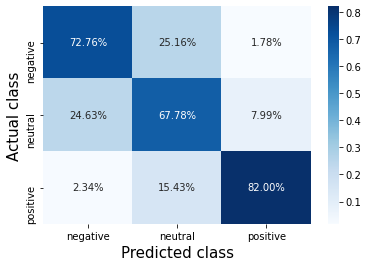

In [32]:
cf_matrix = confusion_matrix(y_test1, y_pred)
cf_matrix = cf_matrix / cf_matrix.astype(np.float).sum(axis=1)

categories = ["negative", "neutral", "positive"]
sns.heatmap(cf_matrix, annot=True, fmt='.2%', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.ylabel('Actual class', fontsize=15)
plt.xlabel('Predicted class', fontsize=15)